<a href="https://colab.research.google.com/github/mish0410/Wallmart-case-study/blob/main/Wallmart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

The Management team at Walmart Inc. wants to analyze the customer purchase behavior (specifically, purchase amount) against the customer’s gender and the various other factors to help the business make better decisions. They want to understand if the spending habits differ between male and female customers: Do women spend more on Black Friday than men? (Assume 50 million customers are male and 50 million are female).


In [ ]:
#import necessary libraries for data analysis
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math


In [ ]:
# get the dataset
!wget "https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/293/original/walmart_data.csv?1641285094"

--2025-10-03 14:37:19--  https://d2beiqkhq929f0.cloudfront.net/public_assets/assets/000/001/293/original/walmart_data.csv?1641285094
Resolving d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)... 18.65.227.25, 18.65.227.196, 18.65.227.110, ...
Connecting to d2beiqkhq929f0.cloudfront.net (d2beiqkhq929f0.cloudfront.net)|18.65.227.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23027994 (22M) [text/plain]
Saving to: ‘walmart_data.csv?1641285094.1’

walmart_data.csv?16 100%[===================>]  21.96M  --.-KB/s    in 0.1s    

2025-10-03 14:37:19 (220 MB/s) - ‘walmart_data.csv?1641285094.1’ saved [23027994/23027994]



In [ ]:
# read dataset into dataframe
df = pd.read_csv('walmart_data.csv')

In [ ]:
#understanding the schema with top 5 rows
print(df.head())

   User_ID Product_ID Gender   Age  Occupation City_Category  \
0  1000001  P00069042      F  0-17          10             A   
1  1000001  P00248942      F  0-17          10             A   
2  1000001  P00087842      F  0-17          10             A   
3  1000001  P00085442      F  0-17          10             A   
4  1000002  P00285442      M   55+          16             C   

  Stay_In_Current_City_Years  Marital_Status  Product_Category  Purchase  
0                          2               0                 3      8370  
1                          2               0                 1     15200  
2                          2               0                12      1422  
3                          2               0                12      1057  
4                         4+               0                 8      7969  


In [ ]:
#understanding the data structure and checking if data have null values
print("Total rows & columns\n")
print("Total rows = ",df.shape[0])
print("Total columns = ",df.shape[1])
print("\nMissing values per column\n")
missing = df.isnull().sum().sort_values(ascending=False)
missing_pct = (df.isnull().mean()*100).sort_values(ascending=False)
mv = pd.concat([missing, missing_pct], axis=1, keys=['missing_count','missing_pct'])
print(mv,"\n")

#understanding different data types our data set has and if there are duplicate rows in the data

print("data types\n\n",df.dtypes)
print("\nDuplicate rows in data =",df.duplicated().sum())


Total rows & columns

Total rows =  550068
Total columns =  10

Missing values per column

                            missing_count  missing_pct
User_ID                                 0          0.0
Product_ID                              0          0.0
Gender                                  0          0.0
Age                                     0          0.0
Occupation                              0          0.0
City_Category                           0          0.0
Stay_In_Current_City_Years              0          0.0
Marital_Status                          0          0.0
Product_Category                        0          0.0
Purchase                                0          0.0 

data types

 User_ID                        int64
Product_ID                    object
Gender                        object
Age                           object
Occupation                     int64
City_Category                 object
Stay_In_Current_City_Years    object
Marital_Status                

Observation:
- the dataset has >0.5 million rows and 10 columns out of which only 1 column is numerical and rest all are either categorical or ordinal
- the data does not have any null values and duplicity


# **Statistical analysis**

In [ ]:
#we will now check the basis statistics for each column including the categorical ones
df.describe(include = 'all')

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
count,5.500680e+05,550068,550068,550068,550068.000000,550068,550068,550068.000000,550068.000000,550068.000000
unique,NaN,3631,2,7,NaN,3,5,NaN,NaN,NaN
top,NaN,P00265242,M,26-35,NaN,B,1,NaN,NaN,NaN
freq,NaN,1880,414259,219587,NaN,231173,193821,NaN,NaN,NaN
mean,1.003029e+06,NaN,NaN,NaN,8.076707,NaN,NaN,0.409653,5.404270,9263.968713
std,1.727592e+03,NaN,NaN,NaN,6.522660,NaN,NaN,0.491770,3.936211,5023.065394
min,1.000001e+06,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,1.000000,12.000000
25%,1.001516e+06,NaN,NaN,NaN,2.000000,NaN,NaN,0.000000,1.000000,5823.000000
50%,1.003077e+06,NaN,NaN,NaN,7.000000,NaN,NaN,0.000000,5.000000,8047.000000
75%,1.004478e+06,NaN,NaN,NaN,14.000000,NaN,NaN,1.000000,8.000000,12054.000000


Observation:
The data has a high variation and the purchase is scattered because te standard deviation is more than half of the mean

# **Outlier Detection**

In [ ]:
# Quartiles & IQR
Q1 = df["Purchase"].quantile(0.25)
Q3 = df["Purchase"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
lower_wisk = df.loc[df['Purchase']>=lower_bound,'Purchase'].min()
upper_wisk = df.loc[df['Purchase']<=upper_bound,'Purchase'].max()

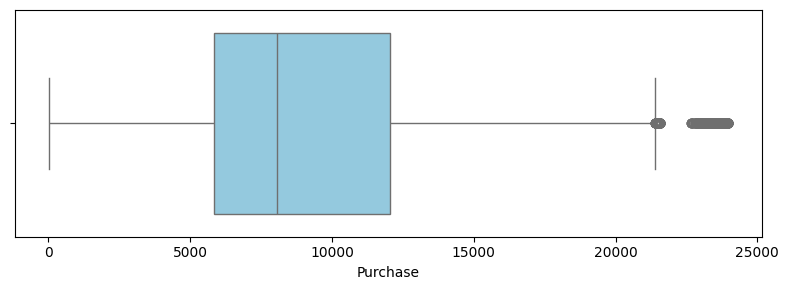

Min purchase excluding outliers = 12.00
Max purchase excluding outliers = 21399.00

1st quartile = 5823.00
3rd quartile = 12054.00

Purchase statistics: mean=9263.97, median=8047.00, mean-median=1216.97
distribution is right-skewed and may have large outliers


In [ ]:
# Boxplot
plt.figure(figsize=(8,3))
sns.boxplot(x='Purchase', data = df, color="skyblue")
plt.xlabel("Purchase")
plt.tight_layout()
plt.show()
print(f"Min purchase excluding outliers = {lower_wisk:.2f}")
print(f"Max purchase excluding outliers = {upper_wisk:.2f}\n")
print(f"1st quartile = {Q1:.2f}")
print(f"3rd quartile = {Q3:.2f}\n")

# Compare mean vs median (simple heuristic for skew/outliers)

mean = df["Purchase"].mean()
median = df["Purchase"].median()
print(f"Purchase statistics: mean={mean:.2f}, median={median:.2f}, mean-median={mean-median:.2f}")
if mean>median:
  print("distribution is right-skewed and may have large outliers")
elif mean < median:
  print("distribution is left-skewed and may have large outliers")
else:
  print("distribution is symmetric and may not have large outliers")




Observation:
- majority of the individual purchase values are between 5823 and 12054
- average purchase across the dataset appears to be ~9264

# **Understanding consumer base- Univariate Analysis**
bifurcating the consumer base on the basis of their gender, age-group, city-category, no. of years they state in that city, their marital status and the product category

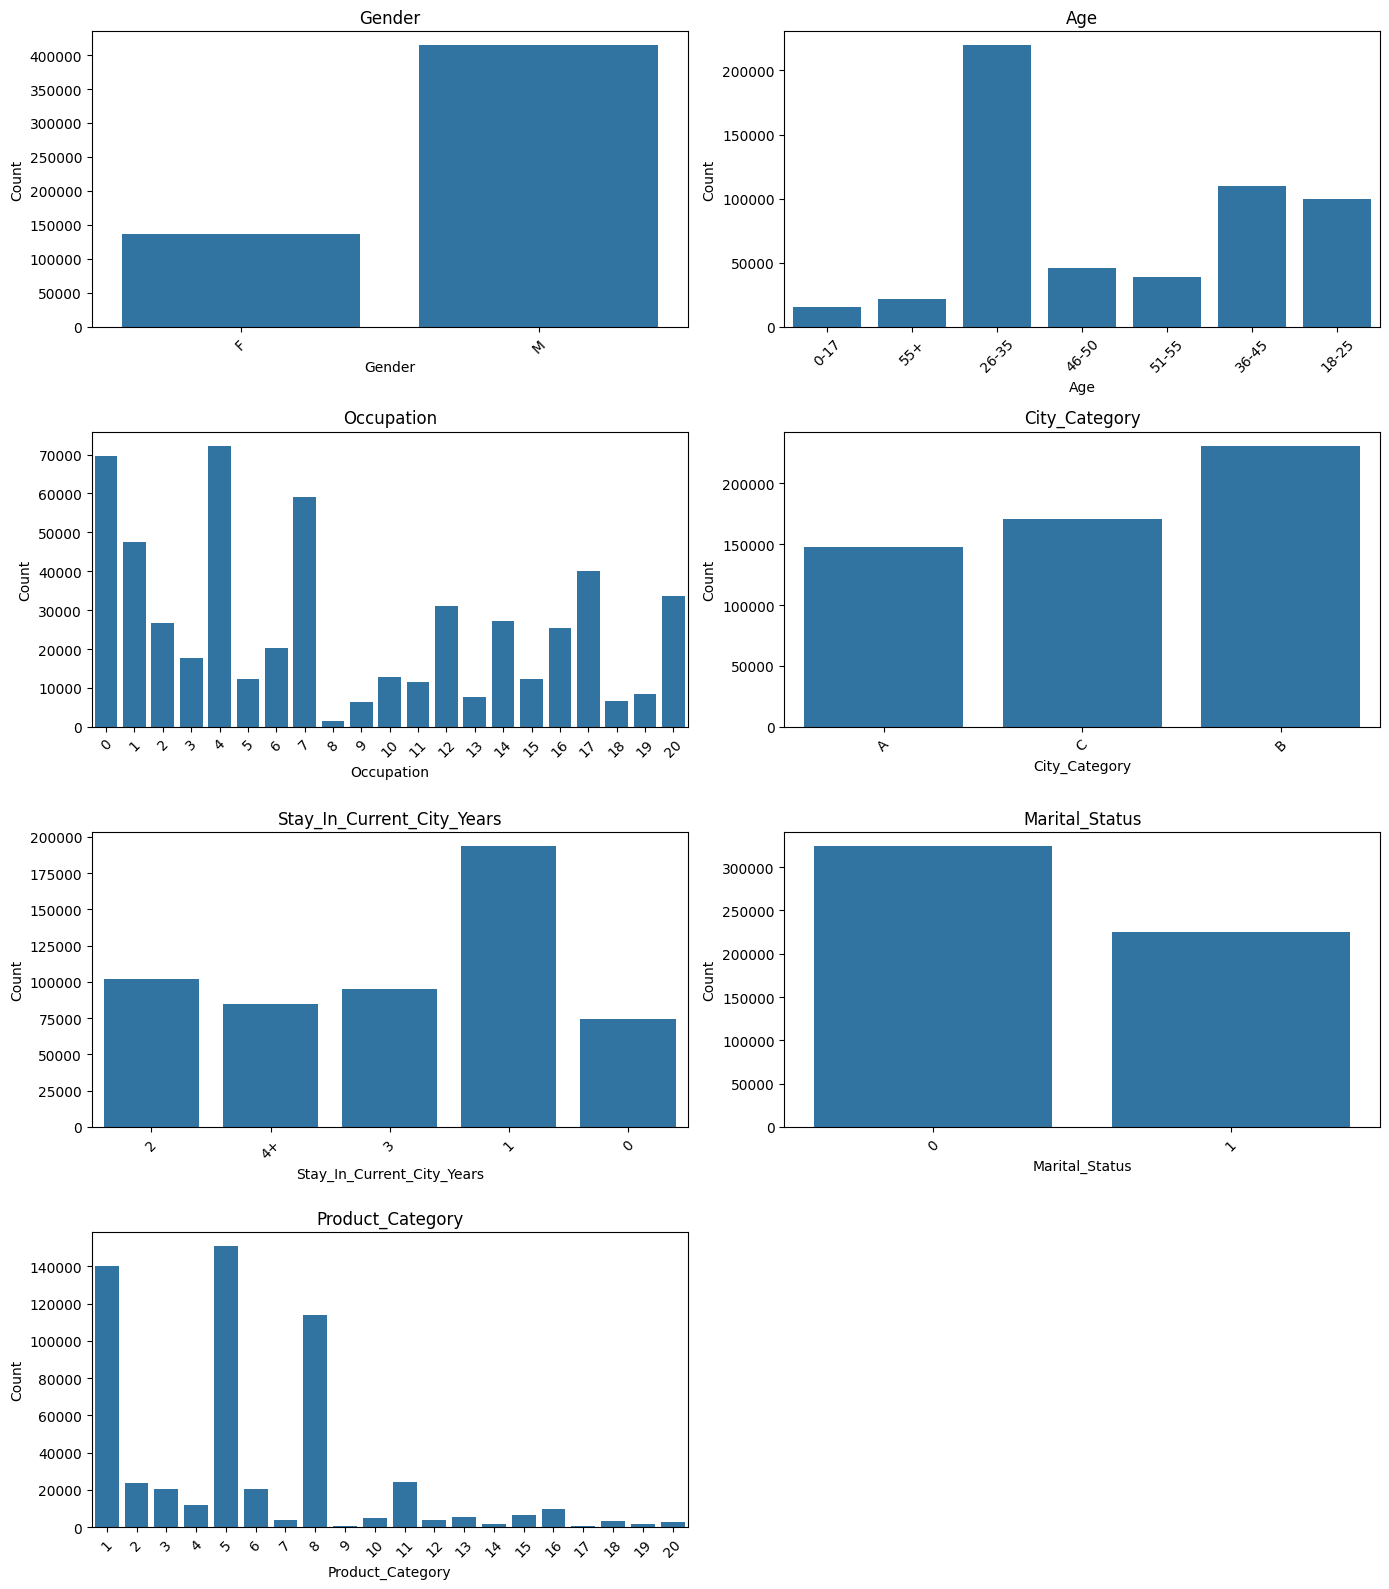

In [ ]:
col = df.columns
remove_list = ['User_ID','Product_ID','Purchase']
col = [c for c in col if c not in remove_list]

# Define subplot grid
n_cols = 2   # number of plots per row
n_plots = len(col)
n_rows = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))

# Flatten axes (works even if single row)
axes = axes.flatten()

# Loop through columns
for i, c in enumerate(col):
    sns.countplot(x=c, data=df, ax=axes[i])
    axes[i].set_title(f"{c}")
    axes[i].set_xlabel(c)
    axes[i].set_ylabel("Count")
    axes[i].tick_params(axis="x", rotation=45)

# Hide unused subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Observations:
- Male shoppers are >3 times of total female shoppers
- >77% of the shoppers are between 18 to 35 years of age out of which 40% are aged between 26-35 i.e. shopping tends to increase when people have either started a new family or they are stablizing in their careers

# **Countinuous variable analysis**

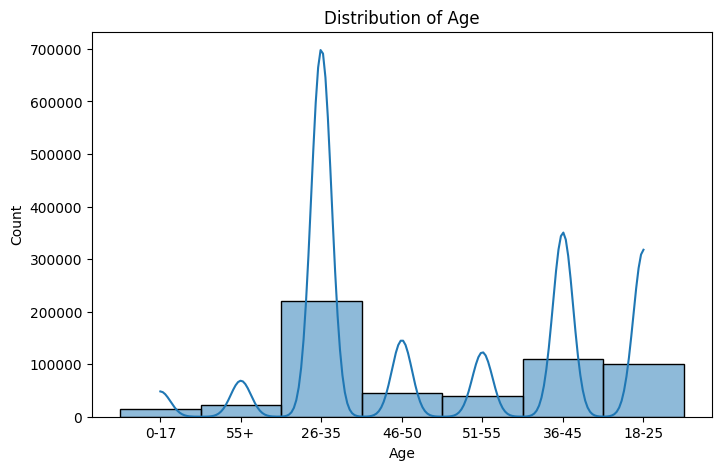

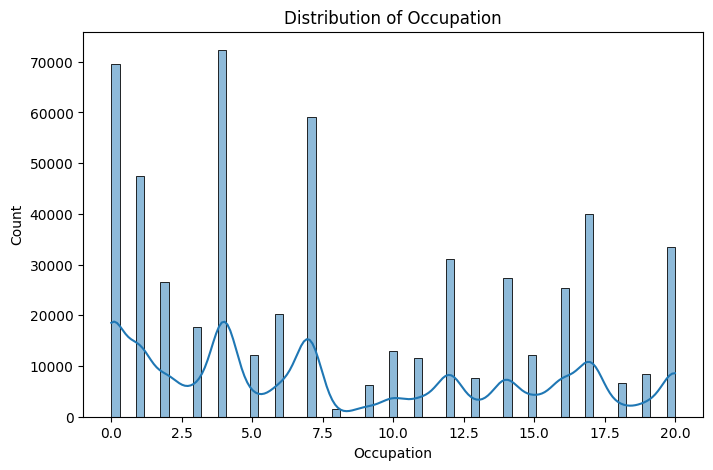

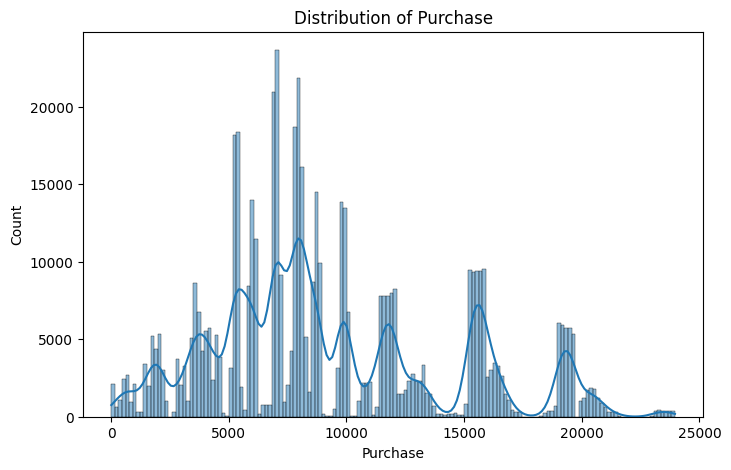

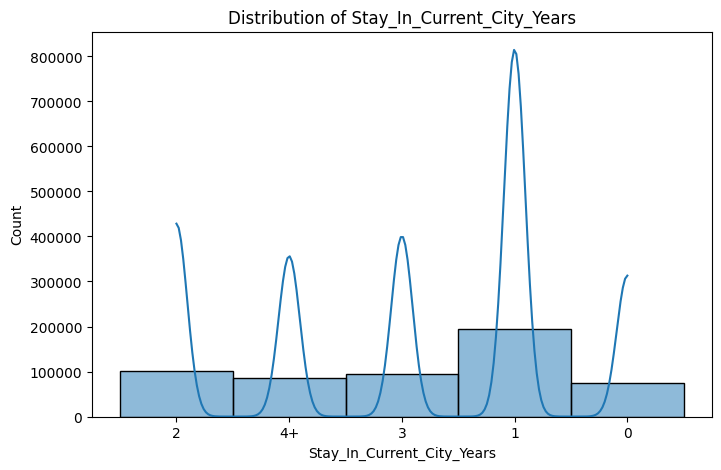

In [ ]:
plt.figure(figsize = (8,5))
sns.histplot(df['Age'], kde=True)
plt.title('Distribution of Age')
plt.show()
plt.figure(figsize = (8,5))
sns.histplot(df['Occupation'], kde=True)
plt.title('Distribution of Occupation')
plt.show()
plt.figure(figsize = (8,5))
sns.histplot(df['Purchase'], kde=True)
plt.title('Distribution of Purchase')
plt.show()
plt.figure(figsize = (8,5))
sns.histplot(df['Stay_In_Current_City_Years'], kde=True)
plt.title('Distribution of Stay_In_Current_City_Years')
plt.show()

Observation:
- Majority of the shoppers are new to the city which means relocation is another driver of sales
- Majority of the people have occupation between 0 to 5, if we assume it as number of years they have been working, it further strengthen our claim of stable career influencing buying behaving however since the data is masked, we leave the interpretation to the company

# **Non-graphical analysis: value counts & uniques**

In [ ]:
cat_cols = ['Gender','Age','City_Category','Stay_In_Current_City_Years','Marital_Status','Product_Category']
for c in cat_cols:
    if c in df.columns:
        print(f"--- {c} ---")
        print(df[c].value_counts(dropna=False))
        print()


--- Gender ---
Gender
M    414259
F    135809
Name: count, dtype: int64

--- Age ---
Age
26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: count, dtype: int64

--- City_Category ---
City_Category
B    231173
C    171175
A    147720
Name: count, dtype: int64

--- Stay_In_Current_City_Years ---
Stay_In_Current_City_Years
1     193821
2     101838
3      95285
4+     84726
0      74398
Name: count, dtype: int64

--- Marital_Status ---
Marital_Status
0    324731
1    225337
Name: count, dtype: int64

--- Product_Category ---
Product_Category
5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: count, dtype: int64



Observation:
- 42% of the shoppers recide in Cities categorized as B which helps to understand the influence of city category on buying behaviour
- 59% of the shoppers have marital status as 0 so it can be claimed that marital status have some influence on shopping behaviour
- 27% of the items sold belongs to product category 5 and 25.5% belongs to product category 1, hence these 2 can be said the most frequent buys

# **Understanding purchasing behavious for each category- Bivariate analysis**

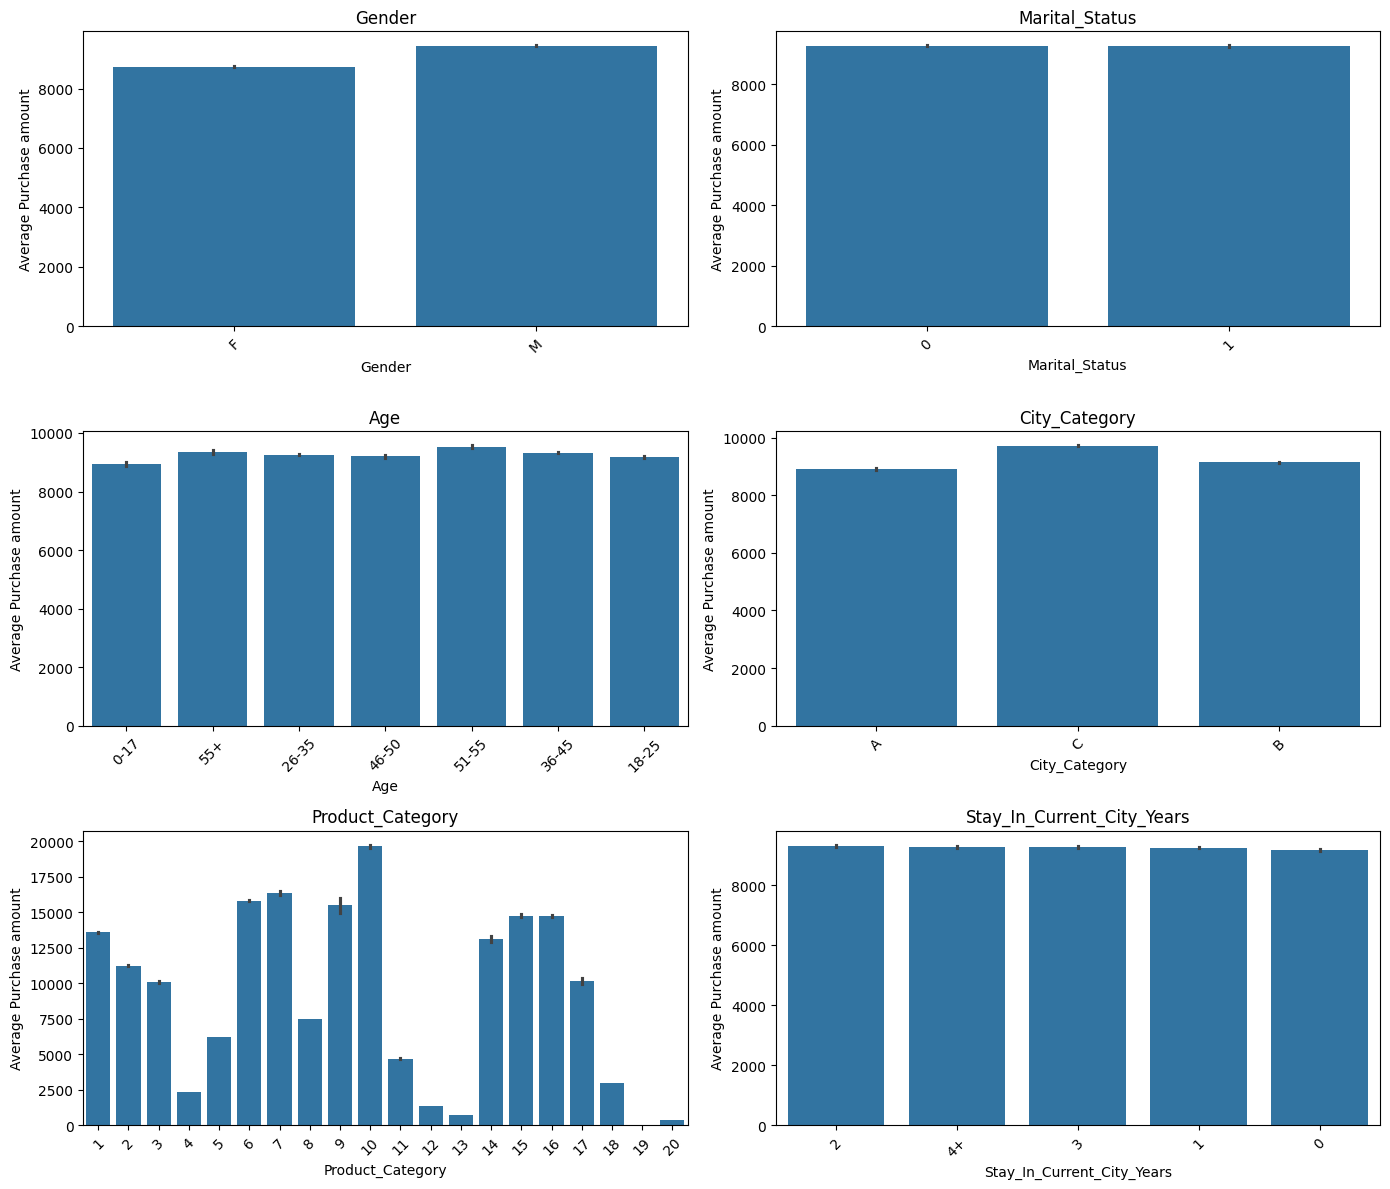


Average Purchase by Gender:
+---+--------+----------+
|   | Gender | Purchase |
+---+--------+----------+
| 0 |   M    | 9437.53  |
| 1 |   F    | 8734.57  |
+---+--------+----------+

Average Purchase by Marital_Status:
+---+----------------+----------+
|   | Marital_Status | Purchase |
+---+----------------+----------+
| 0 |      0.0       | 9265.91  |
| 1 |      1.0       | 9261.17  |
+---+----------------+----------+

Average Purchase by Age:
+---+-------+----------+
|   |  Age  | Purchase |
+---+-------+----------+
| 0 | 51-55 | 9534.81  |
| 1 |  55+  | 9336.28  |
| 2 | 36-45 | 9331.35  |
| 3 | 26-35 | 9252.69  |
| 4 | 46-50 | 9208.63  |
| 5 | 18-25 | 9169.66  |
| 6 | 0-17  | 8933.46  |
+---+-------+----------+

Average Purchase by City_Category:
+---+---------------+----------+
|   | City_Category | Purchase |
+---+---------------+----------+
| 0 |       C       | 9719.92  |
| 1 |       B       |  9151.3  |
| 2 |       A       | 8911.94  |
+---+---------------+----------+

Avera

In [ ]:
group_cols = ['Gender','Marital_Status','Age','City_Category','Product_Category','Stay_In_Current_City_Years']

n_cols = 2   # number of plots per row
n_plots = len(group_cols)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))

# Flatten axes (works even if single row)
axes = axes.flatten()

# Loop through columns
for i, c in enumerate(group_cols):
  if c in df.columns:
    sns.barplot(x=c, y="Purchase", data=df, ax=axes[i], estimator = 'mean')
    axes[i].set_title(f"{c}")
    axes[i].set_xlabel(c)
    axes[i].set_ylabel("Average Purchase amount")
    axes[i].tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

from tabulate import tabulate

for i, c in enumerate(group_cols):
  if c in df.columns:
    table = (
           df.groupby(c)['Purchase']
              .mean()
              .sort_values(ascending=False)
              .reset_index()
        )
    table = table.round(2)
    print(f"\nAverage Purchase by {c}:")
    print(tabulate(table, headers="keys", tablefmt="pretty"))



Inferance :
- Male spends approx 700$ more than female on an average

- there is no significant difference in average spending of a specific marital status
- typically mid-senior/senior people (as per age) are observed to be have more spending average than youngesters however number of buyers in former catogery is way too low then latter
- whiel 42% of overall shoppers reside in city category B, People from City category C seems to have more spending average per transaction than any other city given as part of sample data as their avg spend it atleast ~600$ more than the next highest avg spending city
- there is no significant difference in average spending w.r.t. years stayed in the city hence it can be said that majority of sales is being driven by people who are new in the neighbourhood
- while 52% of the transactions have products from category 1 and 5, the average purchase amount of these category are ~13k and ~6.2k respectively vs the highest avg per category of 19.6k for category 10 however total purchases of items from product category 10 were ~5.1k (<1% of overall purchases)

# **Checking if purchasing behaviour of Female vs male changes with respect to other categories like age and marital status**

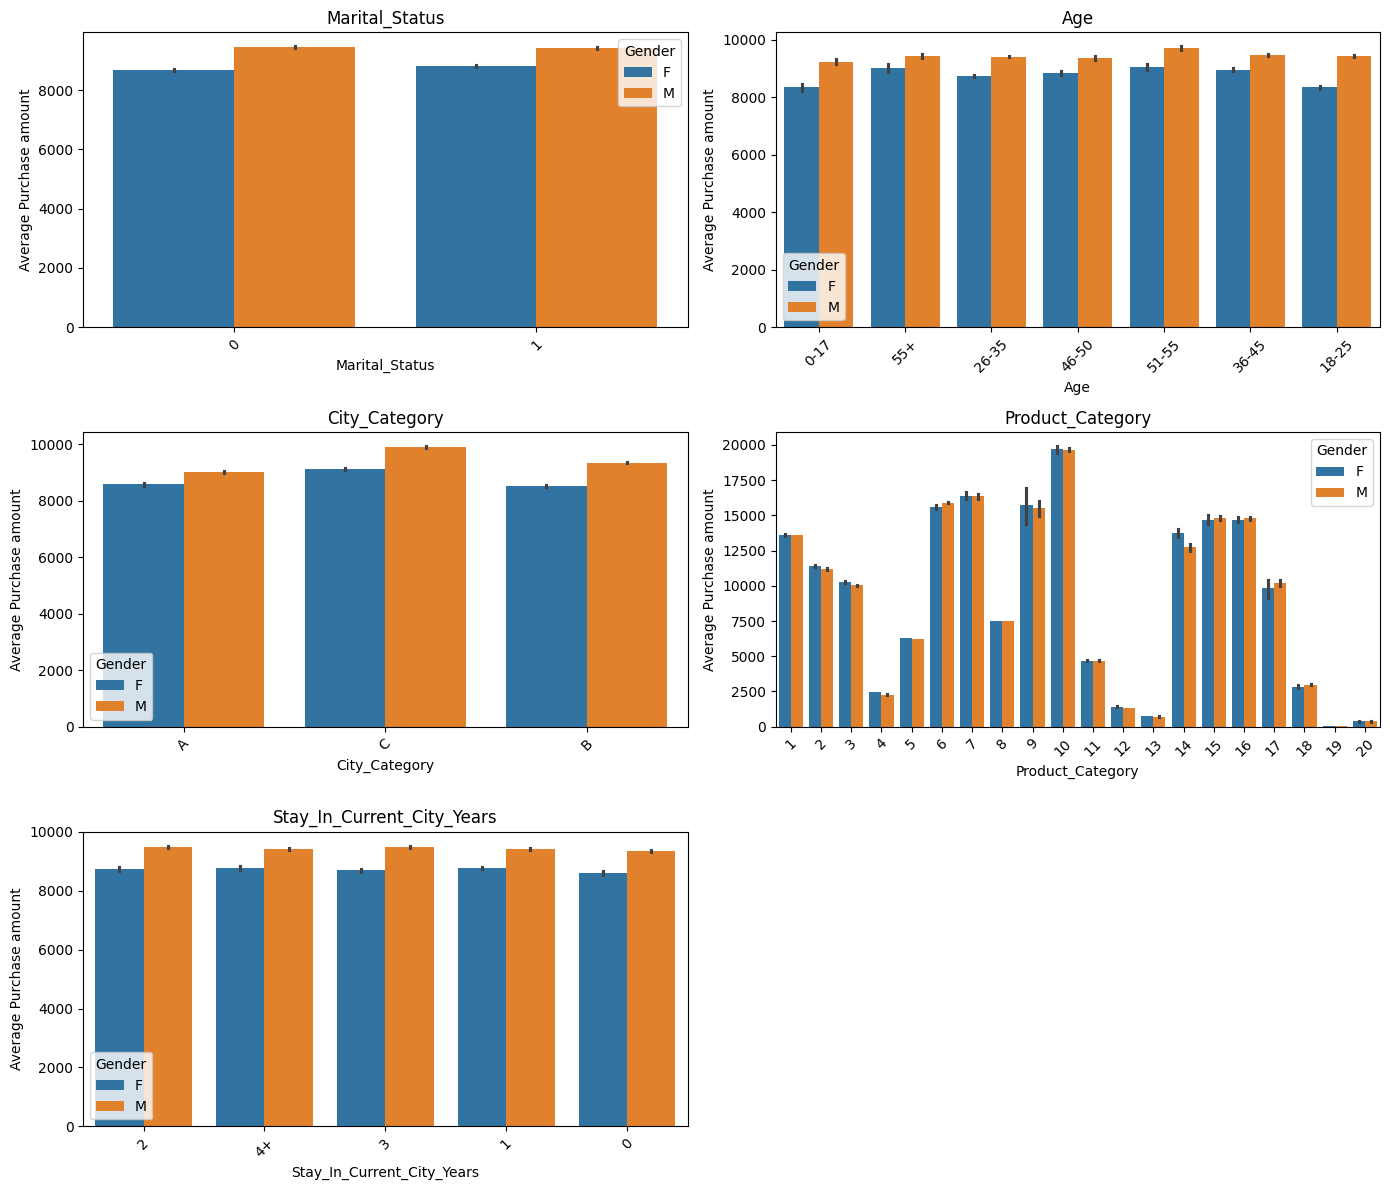

In [ ]:
group_cols2 = ['Marital_Status','Age','City_Category','Product_Category','Stay_In_Current_City_Years']

n_cols = 2   # number of plots per row
n_plots = len(group_cols2)
n_rows = math.ceil(n_plots / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4*n_rows))

# Flatten axes (works even if single row)
axes = axes.flatten()

# Loop through columns
for i, c in enumerate(group_cols2):
  if c in df.columns:
    sns.barplot(x=c, y="Purchase", hue = 'Gender', data=df, ax=axes[i], estimator = 'mean')
    axes[i].set_title(f"{c}")
    axes[i].set_xlabel(c)
    axes[i].set_ylabel("Average Purchase amount")
    axes[i].tick_params(axis="x", rotation=45)
# Hide unused subplots (if any)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

Observation:
- it is observed that male spends more than Female across cities and irrespective of their marital status, number of years stayed in the city and age
- however product categorys have almost equal average purchase from both the gender


# **Population spending interval calculation basis sample averge**

In [ ]:
def clt_confidence_interval(sample, confidence=0.95):
    # sample: 1D array-like numeric
    arr = np.array(sample)
    n = len(arr)
    mean = arr.mean()
    sd = arr.std(ddof=1)
    se = sd / np.sqrt(n)
    alpha = 1 - confidence
    # use t-critical
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    lower = mean - t_crit * se
    upper = mean + t_crit * se
    return mean, sd, n, (lower, upper)

# Example for female:
female = df[df['Gender']=='F']['Purchase']
male = df[df['Gender']=='M']['Purchase']

print("Female:", clt_confidence_interval(female, confidence=0.95))
print("Male:", clt_confidence_interval(male, confidence=0.95))
print(f"basis female sample with 95% confidance it can be assumed that the overall population spending avg will lie between {clt_confidence_interval(female, confidence=0.95)[3][0]:.2f} and {clt_confidence_interval(female, confidence=0.95)[3][1]:.2f}")

Female: (np.float64(8734.565765155476), np.float64(4767.233289291458), 135809, (np.float64(8709.21132117373), np.float64(8759.92020913722)))
Male: (np.float64(9437.526040472265), np.float64(5092.18620977797), 414259, (np.float64(9422.019402055814), np.float64(9453.032678888716)))
basis female sample with 95% confidance it can be assumed that the overall population spending avg will lie between 8709.21 and 8759.92


# **Sample mean overlap test**

In [ ]:
t_stat, p_val = stats.ttest_ind(female, male, equal_var=False, nan_policy='omit')
if p_val < 0.5:
  print("Means are not overlapping")
else:
  print("Means are overlapping")



Means are not overlapping


# **CLT simulation: distribution of sample means (vary sample size)**

Simulation for female



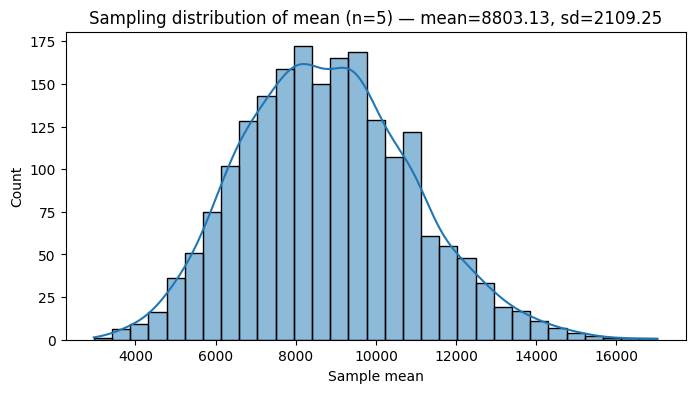

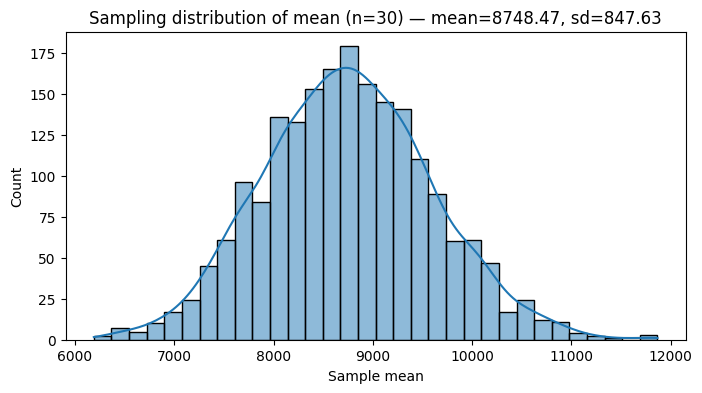

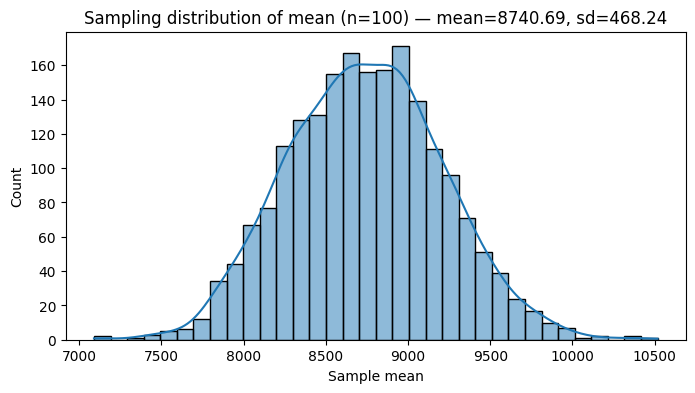

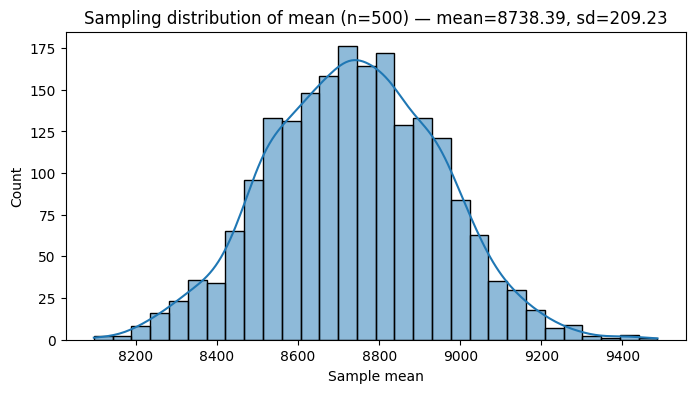

Simulation for male



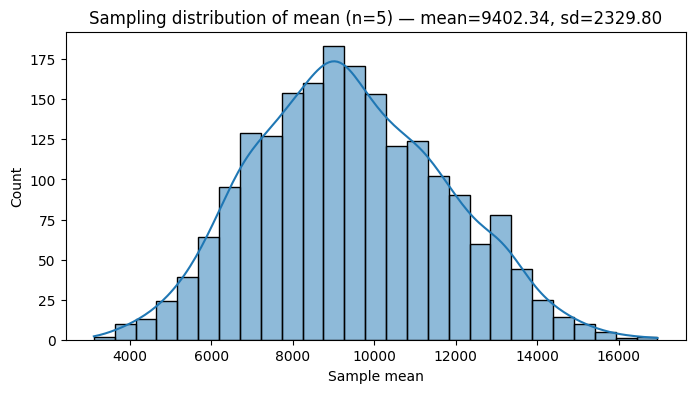

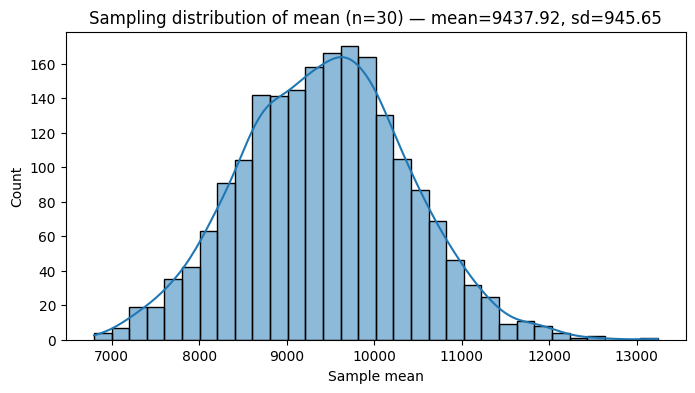

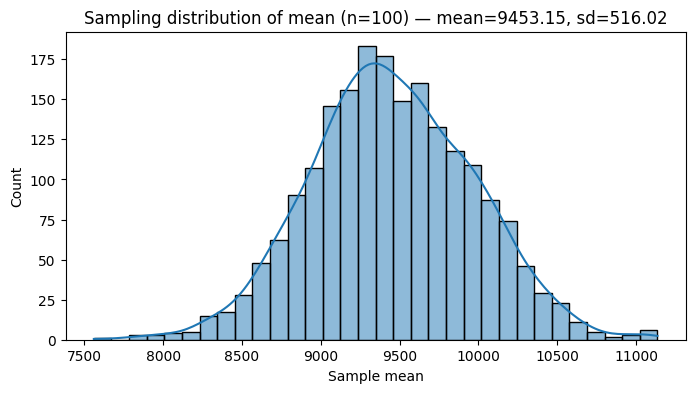

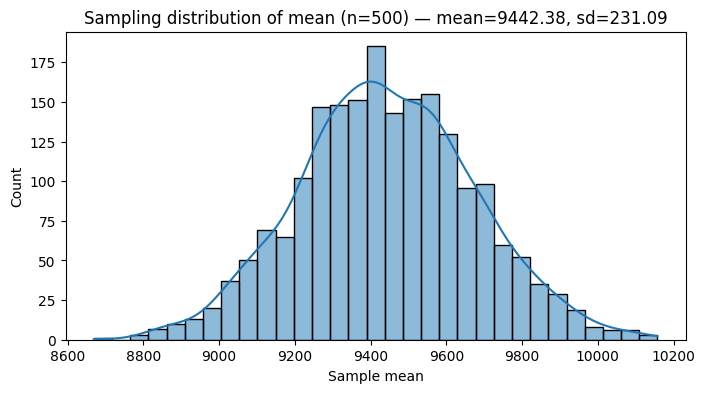

In [ ]:
def clt_simulation(data, sample_sizes=[5,30,100,500], n_sims=2000):
    arr = np.array(data)
    for n in sample_sizes:
        means = []
        rng = np.random.default_rng(0)
        for _ in range(n_sims):
            s = rng.choice(arr, size=n, replace=True)
            means.append(s.mean())
        plt.figure(figsize=(8,4))
        sns.histplot(means, kde=True)
        plt.title(f"Sampling distribution of mean (n={n}) — mean={np.mean(means):.2f}, sd={np.std(means,ddof=1):.2f}")
        plt.xlabel("Sample mean")
        plt.show()

# Run for females and males
print("Simulation for female\n")
clt_simulation(female, sample_sizes=[5,30,100,500], n_sims=2000)
print("Simulation for male\n")
clt_simulation(male, sample_sizes=[5,30,100,500], n_sims=2000)


# **Experiment: Change confidence level and sample size, tabulate results**

Analysis for Gender

In [ ]:
def ci_table(group, sample_sizes=[100,500,1000,5000], confidences=[0.9,0.95,0.99]):
    rows=[]
    for n in sample_sizes:
        # if df smaller than n, sample with replace False if possible
        sample = group.sample(n=n, replace=(len(group)<n), random_state=1)
        for conf in confidences:
            mean, sd, nn, ci = clt_confidence_interval(sample, confidence=conf)
            rows.append({'n':n,'confidence':conf,'mean':mean,'sd':sd,'ci_lower':ci[0],'ci_upper':ci[1],'ci_width':ci[1]-ci[0]})
    return pd.DataFrame(rows)

female_table = ci_table(female, sample_sizes=[100,500,1000,5000], confidences=[0.9,0.95,0.99])
male_table = ci_table(male,   sample_sizes=[100,500,1000,5000], confidences=[0.9,0.95,0.99])
print("\nFemale data analysis\n")
display(female_table)
print("\nMale data analysis\n")
display(male_table)



Female data analysis



,n,confidence,mean,sd,ci_lower,ci_upper,ci_width
0,100,0.90,8985.0000,4620.945885,8217.742232,9752.257768,1534.515536
1,100,0.95,8985.0000,4620.945885,8068.104084,9901.895916,1833.791831
2,100,0.99,8985.0000,4620.945885,7771.352251,10198.647749,2427.295498
3,500,0.90,8893.1060,4866.880897,8534.431921,9251.780079,717.348158
4,500,0.95,8893.1060,4866.880897,8465.475712,9320.736288,855.260577
5,500,0.99,8893.1060,4866.880897,8330.315417,9455.896583,1125.581165
6,1000,0.90,8935.6720,4850.300823,8683.150217,9188.193783,505.043567
7,1000,0.95,8935.6720,4850.300823,8634.688107,9236.655893,601.967786
8,1000,0.99,8935.6720,4850.300823,8539.835140,9331.508860,791.673720
9,5000,0.90,8771.3694,4723.791991,8661.465398,8881.273402,219.808005



Male data analysis



,n,confidence,mean,sd,ci_lower,ci_upper,ci_width
0,100,0.90,9684.5200,5276.448273,8808.423195,10560.616805,1752.193609
1,100,0.95,9684.5200,5276.448273,8637.558189,10731.481811,2093.923621
2,100,0.99,9684.5200,5276.448273,8298.710746,11070.329254,2771.618508
3,500,0.90,9543.3480,5101.371549,9167.392685,9919.303315,751.910630
4,500,0.95,9543.3480,5101.371549,9095.114104,9991.581896,896.467792
5,500,0.99,9543.3480,5101.371549,8953.441666,10133.254334,1179.812667
6,1000,0.90,9506.0450,5092.729453,9240.901626,9771.188374,530.286748
7,1000,0.95,9506.0450,5092.729453,9190.017275,9822.072725,632.055451
8,1000,0.99,9506.0450,5092.729453,9090.423349,9921.666651,831.243302
9,5000,0.90,9441.7286,5068.241110,9323.810626,9559.646574,235.835949


Observation:
from our experiment with sample size and confidence levels, it can be concluded that overall population mean will lie between ~8600 to ~9600 with 99% confidance level
however female population's average spending per transaction would lie between 8600 & 8943 where as male average spending will lie between 9257 and 9626 with 99% confidance level
we can also conclude that with increasing sample size the mean tends to move toward population mean hence proving normal distribution of data (using CLT)

Analysis for Marital status

In [ ]:
def ci_table(group, sample_sizes=[100,500,1000,5000], confidences=[0.9,0.95,0.99]):
    rows=[]
    for n in sample_sizes:
        # if df smaller than n, sample with replace False if possible
        sample = group.sample(n=n, replace=(len(group)<n), random_state=1)
        for conf in confidences:
            mean, sd, nn, ci = clt_confidence_interval(sample, confidence=conf)
            rows.append({'n':n,'confidence':conf,'mean':mean,'sd':sd,'ci_lower':ci[0],'ci_upper':ci[1],'ci_width':ci[1]-ci[0]})
    return pd.DataFrame(rows)

status_0 = ci_table(df.loc[df['Marital_Status']==0,'Purchase'], sample_sizes=[100,500,1000,5000], confidences=[0.9,0.95,0.99])
status_1 = ci_table(df.loc[df['Marital_Status']==1,'Purchase'], sample_sizes=[100,500,1000,5000], confidences=[0.9,0.95,0.99])
print("\nMarital Status 0 data analysis\n")
display(status_0)
print("\nMarital Status 1 data analysis\n")
display(status_1)


Marital Status 0 data analysis



,n,confidence,mean,sd,ci_lower,ci_upper,ci_width
0,100,0.90,9553.8400,4950.098711,8731.929988,10375.750012,1643.820024
1,100,0.95,9553.8400,4950.098711,8571.633023,10536.046977,1964.413955
2,100,0.99,9553.8400,4950.098711,8253.743373,10853.936627,2600.193254
3,500,0.90,9169.7460,5019.108033,8799.853252,9539.638748,739.785497
4,500,0.95,9169.7460,5019.108033,8728.740218,9610.751782,882.011564
5,500,0.99,9169.7460,5019.108033,8589.352357,9750.139643,1160.787286
6,1000,0.90,9290.6170,5022.180561,9029.146622,9552.087378,522.940757
7,1000,0.95,9290.6170,5022.180561,8978.967164,9602.266836,623.299672
8,1000,0.99,9290.6170,5022.180561,8880.752900,9700.481100,819.728201
9,5000,0.90,9267.3794,5077.552994,9149.244775,9385.514025,236.269250



Marital Status 1 data analysis



,n,confidence,mean,sd,ci_lower,ci_upper,ci_width
0,100,0.90,9309.310,5008.581784,8477.689510,10140.930490,1663.240980
1,100,0.95,9309.310,5008.581784,8315.498712,10303.121288,1987.622576
2,100,0.99,9309.310,5008.581784,7993.853347,10624.766653,2630.913306
3,500,0.90,9228.640,5160.946063,8848.294227,9608.985773,760.691545
4,500,0.95,9228.640,5160.946063,8775.171567,9682.108433,906.936866
5,500,0.99,9228.640,5160.946063,8631.844660,9825.435340,1193.590681
6,1000,0.90,9278.480,5094.993454,9013.218755,9543.741245,530.522489
7,1000,0.95,9278.480,5094.993454,8962.311783,9594.648217,632.336434
8,1000,0.99,9278.480,5094.993454,8862.673582,9694.286418,831.612836
9,5000,0.90,9407.672,5082.399980,9289.424605,9525.919395,236.494791


Analysis for Age group

In [ ]:
results = []

for i in df['Age'].unique():
    sample = df.loc[df['Age'] == i, 'Purchase']
    a = [0.01, 0.05, 0.10]   # significance levels
    for j in a:
        lower, upper = clt_confidence_interval(sample, confidence=1-j)[3]
        results.append({
            "age_group": i,
            "confidence_level": 1-j,
            "lower_bound": float(lower),
            "upper_bound": float(upper)
        })

# Convert to DataFrame
ag_df = pd.DataFrame(results)

print(ag_df)


   age_group  confidence_level  lower_bound  upper_bound
0       0-17              0.99  8826.320034  9040.609247
1       0-17              0.95  8851.941436  9014.987845
2       0-17              0.90  8865.049498  9001.879783
3        55+              0.99  9248.243868  9424.317051
4        55+              0.95  9269.295064  9403.265855
5        55+              0.90  9280.065286  9392.495633
6      26-35              0.99  9225.148284  9280.232982
7      26-35              0.95  9231.733561  9273.647705
8      26-35              0.90  9235.102926  9270.278339
9      46-50              0.99  9148.772763  9268.478632
10     46-50              0.95  9163.083936  9254.167458
11     46-50              0.90  9170.406084  9246.845311
12     51-55              0.99  9468.020442  9601.595620
13     51-55              0.95  9483.989875  9585.626187
14     51-55              0.90  9492.160405  9577.455657
15     36-45              0.99  9292.342199  9370.359191
16     36-45              0.95 

# **Business questions and its answer through data analysis**
Q1: Are women spending more money per transaction than men? Why or Why not?
Ans: It has been proven from our analysis that women are not spending more than men in any category. Possible reaoson could be:
1) total women shoppers itself are 25% of overall sample
2) Since 77% of the shoppers are between age 18 to 35, the earnings and family dynamics seems to play pivotal role in influencing buyer demographics hence women employment, wage parity and dependancy on male in family might be a reason behind lower avg spend by females

Q2: Confidence intervals and distribution of the mean of the expenses by female and male customers

Answer:
Female: mean = 8734.56 which is distributed between 8709.21 and 8759.92 with a confidance level of 95%
Male: mean = 9437.53 which is distributed between 9422.02 and 9453.03 with a confidance level of 95%

Q3 Are confidence intervals of average male and female spending overlapping? How can Walmart leverage this conclusion to make changes or improvements?

Answer: No confidance interval are not overlapping and there is a clear distinction between confidance interval of male and female spending basis sample mean analysis.
Since number of women shoppers are less as well as average spend per woman is also ~700 lower than male, Wallmart might want to consider special promotional events and targeted advertisement for Women to increase the diversity like discounts on purchase of x amount only for female shoppers or specific product promotion which is more usable for females

Q4 Results when the same activity is performed for Married vs Unmarried

Answer: considering marital status 0 as unmarried, it seems number of unmarried buyers are 1.5 times of married buyers hoever average purchase amount is approximately same for both the groups.
It can be seen that with a sample size of 5000 married people have slightly more spending avarage than unmarried people and their confidance interval is also slightly on a higher side than unmarried people. which can be interpreted as providing more value to unmarried people might result in sales boost for wallmart

Q5 Results when the same activity is performed for Age

Answer: age group 18 to 35 have average spending between ~9100 to 9300 while age group 51+ have average spending between ~9200 and 9500 which is evidance for growing needs with the age behind possible addition of family members as well as increased earnings driving the needs and wants of an individual

# Final Insights

Based on the exploration and Central Limit Theorem (CLT) analysis:

## Distribution of Variables and Relationships

- The 'Purchase' amount is right-skewed, indicating a higher frequency of lower purchase amounts and fewer high-value transactions.
- While there are outliers in 'Purchase', they do not seem to be extreme enough to warrant removal for this analysis, as they represent actual high-value purchases.
- The dataset is dominated by male shoppers (more than 3 times the number of female shoppers).
- The majority of shoppers are in the 18-35 age range, with the 26-35 group being the largest.
- City Category B has the highest number of shoppers, followed by C and then A.
- A significant portion of shoppers have been in their current city for only 1 year.
- The number of unmarried shoppers is higher than married shoppers.
- Product Categories 1 and 5 are the most frequently purchased.

## Comments on Univariate Plots

- **Gender:** The count plot clearly shows the imbalance in the number of male and female shoppers in the sample.
- **Age:** The age distribution highlights the concentration of shoppers in the younger to middle-aged groups (18-35).
- **Occupation:** The distribution of occupation is varied, suggesting a diverse customer base.
- **City_Category:** The plot shows the number of shoppers in each city category, with City B having the highest count.
- **Stay_In_Current_City_Years:** The distribution indicates that newer residents (staying 1 year or less) are a significant portion of the customer base.
- **Marital_Status:** The plot shows that unmarried individuals are more frequent shoppers in this dataset.
- **Product_Category:** The plot reveals the popularity of certain product categories over others based on transaction counts.

## Comments on Bivariate Plots

- **Gender vs. Purchase:** The bar plot visually confirms that the average purchase amount for males is higher than for females.
- **Marital_Status vs. Purchase:** The plot shows that marital status has a negligible impact on the average purchase amount per transaction.
- **Age vs. Purchase:** While the overall numbers of younger shoppers are higher, the average purchase amount per transaction is slightly higher for older age groups (51-55, 55+).
- **City_Category vs. Purchase:** City Category C shows a slightly higher average purchase amount per transaction compared to A and B, despite having fewer shoppers than B.
- **Product_Category vs. Purchase:** This plot clearly shows that while some product categories have high transaction counts (like 1 and 5), categories like 10, 7, and 6 have significantly higher average purchase amounts per transaction.
- **Stay_In_Current_City_Years vs. Purchase:** The average purchase amount is relatively similar across different durations of stay in the current city.

## Comments on Generalizing to Population

- **Gender:** Based on the CLT analysis, we can be 99% confident that the true average spending for the female population is between ~8600 and ~8943, and for the male population, it's between ~9257 and ~9626. The confidence intervals do not overlap, strongly suggesting that the average spending between genders is statistically different in the overall population.
- **Marital Status:** The CLT analysis for marital status shows overlapping confidence intervals for average spending between married and unmarried individuals, suggesting that the difference in average spending observed in the sample may not be statistically significant in the overall population.
- **Age:** The CLT analysis for age groups provides confidence intervals for average spending within each group. While there are some overlaps, certain age groups (like 51-55 and 36-45) show slightly higher average spending ranges at higher confidence levels compared to younger groups.

## Recommendations (10 Points)

Here are 10 actionable recommendations for Walmart based on this analysis:

1. **Targeted Marketing for Women:** Implement marketing campaigns specifically aimed at increasing female shopper traffic and average transaction value. This could include promotions, product bundles, or loyalty programs designed to appeal to women.
2. **Understand High-Value Product Categories:** Investigate why product categories 10, 7, and 6 have the highest average purchase amounts. Stocking more of these items, highlighting them in displays, or running promotions on them could increase overall revenue.
3. **Focus on City Category C:** Explore strategies to attract more shoppers from City Category C, as they demonstrate a higher average spending per transaction. This could involve targeted advertising, localized promotions, or even considering store expansion in similar demographic areas.
4. **Leverage Age Group Spending Habits:** Tailor marketing and product offerings to different age groups. While younger shoppers are numerous, higher-value items could be marketed towards older age groups (51+ and 36-45) who have a higher average spend.
5. **Capitalize on New Residents:** Since a large portion of shoppers are new to the city, consider "welcome" promotions or partnerships with local moving companies or real estate agents to attract this demographic.
6. **Analyze Product Category 1 and 5 Popularity:** Despite lower average purchase values, Product Categories 1 and 5 have high transaction counts. Analyze the reasons for their popularity and consider strategies to increase the average basket size for these categories (e.g., suggesting complementary items).
7. **Further Investigate Gender Spending Disparity:** Conduct qualitative research (surveys, focus groups) to understand the underlying reasons for the difference in average spending between men and women. This could provide deeper insights for targeted strategies.
8. **Monitor Marital Status Trends:** Although currently not a significant factor in average spending, continue to monitor purchasing behavior based on marital status as demographic trends change.
9. **Optimize Store Layout and Product Placement:** Based on popular product categories and age group preferences, optimize store layouts and product placements to encourage higher-value purchases and improve the shopping experience for different demographics.
10. **Utilize Data for Personalized Offers:** Implement a system to use customer data (age, city category, past purchases) to provide personalized offers and recommendations, potentially increasing both frequency of visits and average transaction value.